# Quanitifed Self Project

Katie Imhof and John Stirrat  
CPSC 222, Fall 21

### Introduction

* The domain that we chose to look at for this project is our Spotify listening data. The reasons we decided to use this domain was because we both enjoy listening to music a lot, and thought it would be interesting to analyze our listening habits, since we both spend a lot of time using Spotify.
* The data from Spotify is in JSON files.
* There is one table from this dataset, and it is collected whenever a song is listened too, where all of the attributes (listed below) are recorded. 
* The attributes this data has are:
    * Date and End time (which we will split and use as two seperate attributes)
        * Continuous and interval
    * Artist Name
        * Categorical/discrete and nominal
    * Track Name
        * Categorical/discrete and nominal
    * Time played in Ms
        * Continuous and interval
* We are interested in trying to classify the amount of time spent listening based on external factors.
* The impact of our results could lead to change in our listening habits, and could also help us understand why we listen to music more than other times.
* Potential stakeholders that could be interested in our results could be businesses like radio stations, stores, restaurants, etc, since they could potentially find the best times to play ads since they will see what factors influence listening time, so they may have an interest in our project.


### Data Analysis

#### Loading and Cleaning Data:

The cleaning that I did was to separate the "endTime" attribute into the separate date and end time values, since they will be more usable and relevant if they are separate. We will also use date as a foreign key to join tables in the future, so it will be better if that is its own column.

In [18]:
import utils
import pandas as pd

john_stream_hist_df = utils.get_spotify_df("JohnStreamingHistory0.json")

katie_stream_hist_df = utils.get_spotify_df("KatieStreamingHistory0.json")

#### Hypothesis Testing

Problem:
* Using the Spotify data, is the mean amount of time (in milliseconds) John listened to music between November 2020 and January 2021 greater than the mean amount of time Katie listened to music between November 2020 and January 2021?

Type of Hypothesis T-Test:
* An independent, two sample, one-tailed test will be performed. It's an independent test because the two groups didn't have an affect on each other, they are unrelated. It's a two sample test because there are two groups. It's a one-tailed test because we are comparing the mean amount of time listened of the two groups. A one-tailed test will be more helpful because we want $H_1$ to state a direction.

##### Step 1: State the null and alternate hypothesis

$H_0$: $\mu_{John}\leq \mu_{Katie}$


$H_1$: $\mu_{John} > \mu_{Katie}$

##### Step 2: Select the level of significance

$\alpha$ = 0.05

##### Step 3: Select the appropriate test statistic

$t=\frac{\overline{X_{John}} - \overline{X_{Katie}}}{\sqrt{s_p^2(\frac{1}{n_{John}}+\frac{1}{n_{Katie}})}}$

##### Step 4: Formulate the decision rule

First, we need to grab the dates we want which is November 2020 to January 2021, two months worth of data.

In [19]:
katie_date_df = katie_stream_hist_df["2020-11-01":"2021-01-01"]
john_date_df = john_stream_hist_df["2020-11-01":"2021-01-01"]

Now we want to grab the "msPlayed" column to grab the amount of music we listened to during those months.

In [20]:
katie_ms_played = katie_date_df["msPlayed"]
john_ms_played = john_date_df["msPlayed"]

Next, we need to find n for each group (the total amount of days that we're using).

In [21]:
n_katie = len(katie_ms_played)
n_john = len(john_ms_played)

In [22]:
df = n_katie + n_john - 2
print("df:", df)

df: 5627


Since it's a one-tailed test, $\alpha$ = 0.05 and df = 5627

Looking at the t-table, t-critical is 1.645.

If t-computed > 1.645, then reject $H_0$.

If t-computed <= 1.645, do not reject $H_0$.

### Step 5: Make a decision

Using SciPy, we will now calculate t-computed.

In [23]:
import scipy.stats as stats

t, p = stats.ttest_ind(john_ms_played, katie_ms_played)
print("t:", t, "p:", p / 2)

t: 6.863307298918676 p: 3.7260903946574615e-12


Since t-computed (6.86) > t-critical (1.645), reject $H_0$, $\mu_{John} > \mu_{Katie}$.

Also, p-value < $\alpha$ (0.05) => reject $H_0$.

Conclusion:
* At the 0.05 level of significance, the mean amount of time (in milliseconds) that John listened to music between November 2020 and January 2021 appears to be greater than the mean amount of time Katie listened to music between November 2020 and January 2021.

#### Visualizations

In order to display the data in a way that's easy to understand, we're going to convert the amount of time from milliseconds to seconds of the sample means.

In [24]:
import numpy as np

Xbar_john = np.mean(john_ms_played)
Xbar_katie = np.mean(katie_ms_played)

Xbar_seconds_john = Xbar_john / 1000
Xbar_seconds_katie = Xbar_katie / 1000

To show John's mean compared to Katie's mean, we are going to use a pie chart, using the matplotlib library.

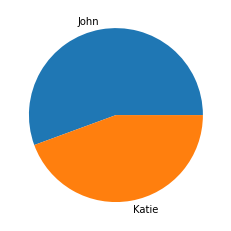

In [25]:
import matplotlib.pyplot as plt

means_list = [Xbar_seconds_john, Xbar_seconds_katie]
label = ["John", "Katie"]

plt.pie(means_list, labels=label)
plt.show()

On average, John listens to music more often than Katie.

# kNN Classification

For this classification task, we will be training a kNN classifier to see if it can accurately predict which one of us listened to a song based off of what time of day we were listening, what day of the week it was, and how much we listened to the song. 

To do this, the first step is to join our data with a table that contains the day of the week for a certain date. We used the table of date provided for DA3 for the days of the week.   
The problem with using this table was, however, that the date was provided in this table was in a different format than the Spotify datasets, so we had to reformat it so it would match, and then could be used to join the two tables.

Another problem was that the time of day was presented as a string, so we went through and decoded it to a numerical value. We also condensed each time into the hour of the day it was to help make the data easier to understand and use in the classifier

The next step is to add an attribute to the individual data sets that classifies which dataset it comes from, and this can be done by adding a column to both of our dataframes that contains our reespective names for each instance

Then, once this is all done, we can combine our data into one large dataframe, which will be ready for use

In [26]:
days_df = pd.read_csv("days_of_week.csv")

for i in range(len(days_df["Date"])):
    item_list = days_df["Date"][i].split("/")
   
    for j in range(len(item_list)):
        for num in range(1, 10, 1):
            if item_list[j] == str(num):
                item_list[j] = "0" + str(num)

    days_df["Date"][i] = "20" + item_list[2] + "-" + item_list[0] + "-" + item_list[1]
    

days_df.set_index("Date", inplace=True)

john_weekday_df = john_date_df.join(days_df)
katie_weekday_df = katie_date_df.join(days_df)

utils.decode_endTime_column(john_weekday_df)
utils.decode_endTime_column(katie_weekday_df)

john_weekday_df["Name"] = "John"
katie_weekday_df["Name"] = "Katie"

full_weekday_df = john_weekday_df.append(katie_weekday_df)

print(full_weekday_df)

c:\Users\johnu\project\utils.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["endTime"][i] = 1
c:\Users\johnu\project\utils.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["endTime"][i] = 2
c:\Users\johnu\project\utils.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["endTime"][i] = 19
c:\Users\johnu\project\utils.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

                        artistName  \
2020-11-01    Bring Me The Horizon   
2020-11-01    Bring Me The Horizon   
2020-11-01    Bring Me The Horizon   
2020-11-01    Bring Me The Horizon   
2020-11-01    Bring Me The Horizon   
...                            ...   
2021-01-01         John Mellencamp   
2021-01-01              Elton John   
2021-01-01  Dexys Midnight Runners   
2021-01-01               Foreigner   
2021-01-01              38 Special   

                                              trackName  msPlayed endTime  \
2020-11-01    Itch For The Cure (When Will We Be Free?)       341       1   
2020-11-01                 Kingslayer (feat. BABYMETAL)         0       1   
2020-11-01                 Kingslayer (feat. BABYMETAL)    220041       1   
2020-11-01                       1x1 (feat. Nova Twins)    209598       1   
2020-11-01                                       Ludens      4728       1   
...                                                 ...       ...     ...   
2021

Now that the data is useable, we can now set up the classifier and do the classification

Before we do anything, lets visualize the data to help us make better hypotheses about the classifier and to help understand the data better

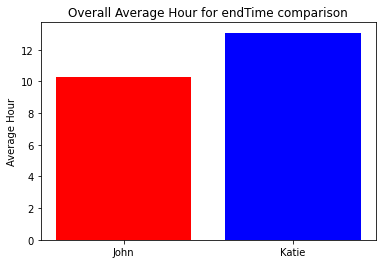

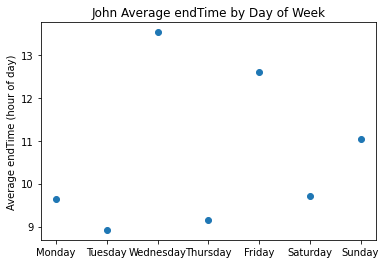

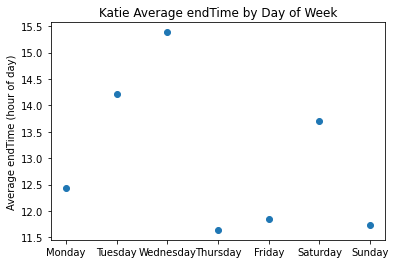

In [27]:
plt.figure()
plt.bar([1], [john_weekday_df["endTime"].mean()], color="red")
plt.bar([2], [katie_weekday_df["endTime"].mean()], color="blue")
plt.xticks([1, 2], ["John", "Katie"])
plt.ylabel("Average Hour")
plt.title("Overall Average Hour for endTime comparison")

utils.print_avg_endtime_by_weekday_plot(john_weekday_df, "John")
utils.print_avg_endtime_by_weekday_plot(katie_weekday_df, "Katie")

From this visualiztaion, we can see that there is a moderate difference in the average time of day for both of us, and this is also reflected in the charts for each day.

Before actually doing the classification, the hypothesis that we had was that trying to classify the "Name" attribute was that this may work fairly well, but since we are not going to be using artistName or trackName in this test, it may not be the most accurate, since these numbers could vary wildly and not necessarily have a definite pattern.

Below is the code for the actual kNN classification:

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

scaler = MinMaxScaler()
day_encoder = LabelEncoder()

X = full_weekday_df.drop("Name", axis=1)
X = X.drop("artistName", axis=1)
X = X.drop("trackName", axis=1)
y = full_weekday_df["Name"]

day_encoder.fit(["Monday", "Tuesday", "Wednesday","Thursday", "Friday", "Saturday", "Sunday"])
X["Day of Week"] = day_encoder.transform(X["Day of Week"])

X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

knn_clf = KNeighborsClassifier(n_neighbors=30, metric="euclidean")
knn_clf.fit(X_train, y_train)

y_predicted = knn_clf.predict(X_test)

accuracy = knn_clf.score(X_test, y_test)
print("kNN Accuracy: ", accuracy)

kNN Accuracy:  0.8259943181818182


From just this classifier alone, it seems that it ended up working fairly well, since it ended up having an accuracy of arund 81-83%


Now that we have this classifier, we can compare it to a different kind of classifier to test its accuracy. The first kind of classifer we decided to compare it to is a decision tree classifer, shown below. We also included a figure of the decision tree, but since it is so big, it is hard to read. It does help show a little insight into what is happening even if it is hard to look at.

Decision Tree Accuracy:  0.8110795454545454


[Text(217.62000000000003, 199.32, 'msPlayed <= 0.103\ngini = 0.352\nsamples = 4221\nvalue = [961, 3260]\nclass = John'),
 Text(133.92000000000002, 163.07999999999998, 'endTime <= 0.674\ngini = 0.341\nsamples = 4164\nvalue = [907, 3257]\nclass = John'),
 Text(66.96000000000001, 126.83999999999999, 'endTime <= 0.326\ngini = 0.421\nsamples = 1984\nvalue = [597, 1387]\nclass = John'),
 Text(33.480000000000004, 90.6, 'msPlayed <= 0.056\ngini = 0.381\nsamples = 1803\nvalue = [461, 1342]\nclass = John'),
 Text(16.740000000000002, 54.359999999999985, 'endTime <= 0.022\ngini = 0.422\nsamples = 1446\nvalue = [438, 1008]\nclass = John'),
 Text(8.370000000000001, 18.119999999999976, 'gini = 0.243\nsamples = 268\nvalue = [38, 230]\nclass = John'),
 Text(25.110000000000003, 18.119999999999976, 'gini = 0.449\nsamples = 1178\nvalue = [400, 778]\nclass = John'),
 Text(50.220000000000006, 54.359999999999985, 'msPlayed <= 0.091\ngini = 0.121\nsamples = 357\nvalue = [23, 334]\nclass = John'),
 Text(41.850

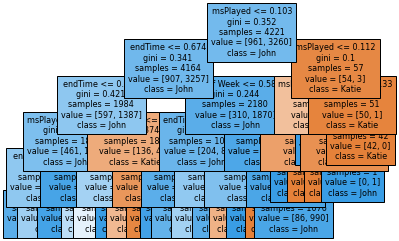

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

tree_clf = DecisionTreeClassifier(max_depth=5)

X = full_weekday_df.drop("Name", axis=1)
X = X.drop("artistName", axis=1)
X = X.drop("trackName", axis=1)
y = full_weekday_df["Name"]

day_encoder.fit(["Monday", "Tuesday", "Wednesday","Thursday", "Friday", "Saturday", "Sunday"])
X["Day of Week"] = day_encoder.transform(X["Day of Week"])

tree_clf.fit(X_train, y_train)

y_predicted = tree_clf.predict(X_test)

accuracy = tree_clf.score(X_test, y_test)
print("Decision Tree Accuracy: ", accuracy)

plot_tree(tree_clf, feature_names=X.columns, class_names={0: "Katie", 1: "John"}, filled=True, fontsize=8)

This classifer had a very similar accuracy, so i think that either one could be used and get pretty much the same results.

The way that we tested the accuracy of these classifiers was through scikitlearn's `.score()` method, which returns a value that represents the accuracy based on the data given and the corresponding class values. This gives us a good idea of how the classifier is working, and how it responds to changes to our process.

The problems with classification that we faced was having to remove and not use some of our attributes that likely would have made this classifier very accurate, which is the artist and track name attributes. Since these are purely categorical, and there is a potentially infinite number for each one, it does not seem viable to tray and label encode them. However, for future changes we could pursue on this project, we could find other ways to be able to include these, like maybe using a different classifer or finding a viable way to turn these values into useable numerical data.

We also should remember that even though this accuracy may seem high, it potentially could not be the best classifier, and could not work in other cases. Since this is a relatively low stakes project, where no one is being put at risk, it does not need to be the top concern, but it should be held in mind that this is subject to not being as accurate as the data states.

## NLP

Below is code that shows a wordcloud for each of us that will visualize the frequency of the words in our artistName and trackName columns:

John artistName:


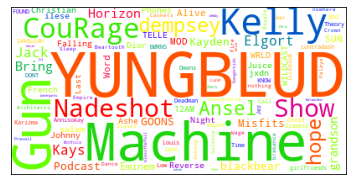

Katie artistName:


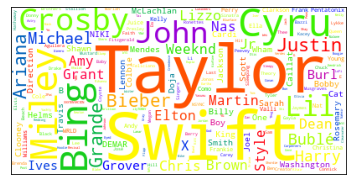

John trackName:


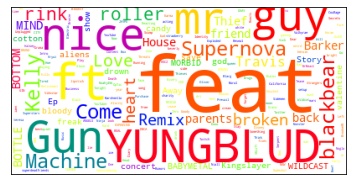

Katie trackName:


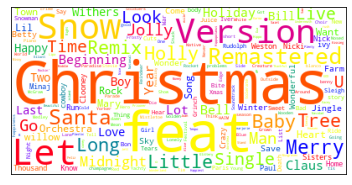

In [30]:
print("John artistName:")
utils.generate_wordcloud(john_weekday_df["artistName"])
print("Katie artistName:")
utils.generate_wordcloud(katie_weekday_df["artistName"])
print("John trackName:")
utils.generate_wordcloud(john_weekday_df["trackName"])
print("Katie trackName:")
utils.generate_wordcloud(katie_weekday_df["trackName"])

## Conclusion:

The dataset we used, the Spotify streaming data, ended up working fairly well for this project since it has a mix of numerical and categorical attributes. It also was sorted by date, which ended up being a great way to join tables to provide more data for classification, which was great. However, it had to be cleaned and manipulated to be able to be useable more than we were expecting. Not only did we have to spilt one of the provided attributes into 2 different attributes, we also had to go through and convert the endTime attribute to more usable data. 

The classifier we developed uses the kNN method to take attributes with provided class labels, and then uses the distance (on a euclidean plane) from wherever that unseen instance is to predict whether or not the instance is from John's dataset or Katie's dataset. We ended up finding out that it had an accuracy of around 81-83%, which seems pretty good, but also could be improved. A few ideas we had to improve this would be to:
* Somehow codify artists and tracks to be able to be factored in to the distance
* Manipulate the number of neighbors to see if we can the optimal amount
* Use a larger range of dates for our data

The potential impacts of this project could be to help track our listening habits, and find when we listen to music the most. It also could be used to figure out who is more likely listening to music based on the data like time of day, day of the week, how long a person is listening for. The ethical impact of this is that it could potential be used to target certain people, like if a companies knows it is likely one or the other of use listening to music, they could traget ads to us or somehow use that data to make a profit, which could be negative if left unchecked.